In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 65 (delta 33), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (65/65), 5.66 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
from earlystop import Earlystop

In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(9),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/validation', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [8]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [9]:
def ConvBlock(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

In [10]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),
            
            ConvBlock(512, 512),
            nn.MaxPool2d(2,2),
            
        
        )
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512,output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [11]:
model = CNNpenyakitPadi(len(train_set.classes))
model

CNNpenyakitPadi(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Sequential(
      (0): 

In [12]:
from tqdm import tqdm

In [13]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc


In [14]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 100

Test: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Epoch 1: train_loss=1.7681, val_loss=1.7584, train_score=0.2522, val_score=0.2841


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 2: train_loss=1.7037, val_loss=1.6692, train_score=0.4499, val_score=0.5000


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 3: train_loss=1.6313, val_loss=1.5998, train_score=0.5588, val_score=0.5511


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 4: train_loss=1.5728, val_loss=1.5499, train_score=0.6062, val_score=0.5758


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 5: train_loss=1.5266, val_loss=1.5093, train_score=0.6095, val_score=0.5890


Test: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 6: train_loss=1.4884, val_loss=1.4893, train_score=0.6242, val_score=0.6004


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 7: train_loss=1.4655, val_loss=1.4610, train_score=0.6329, val_score=0.6136


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 8: train_loss=1.4451, val_loss=1.4480, train_score=0.6465, val_score=0.6193


Test: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 9: train_loss=1.4338, val_loss=1.4369, train_score=0.6481, val_score=0.6345


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 10: train_loss=1.4220, val_loss=1.4245, train_score=0.6487, val_score=0.6402


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 11: train_loss=1.4162, val_loss=1.4178, train_score=0.6476, val_score=0.6402


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 12: train_loss=1.4051, val_loss=1.4080, train_score=0.6612, val_score=0.6477


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 13: train_loss=1.3949, val_loss=1.4046, train_score=0.6667, val_score=0.6439


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 14: train_loss=1.3874, val_loss=1.3945, train_score=0.6781, val_score=0.6591


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 15: train_loss=1.3790, val_loss=1.3874, train_score=0.6874, val_score=0.6705


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 16: train_loss=1.3745, val_loss=1.3814, train_score=0.6977, val_score=0.6818


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 17: train_loss=1.3641, val_loss=1.3754, train_score=0.7048, val_score=0.6932


Test: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Epoch 18: train_loss=1.3633, val_loss=1.3664, train_score=0.7042, val_score=0.7027


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 19: train_loss=1.3598, val_loss=1.3616, train_score=0.7048, val_score=0.7045


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 20: train_loss=1.3500, val_loss=1.3580, train_score=0.7179, val_score=0.7083


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 21: train_loss=1.3511, val_loss=1.3506, train_score=0.7168, val_score=0.7102


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 22: train_loss=1.3453, val_loss=1.3483, train_score=0.7239, val_score=0.7121


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 23: train_loss=1.3422, val_loss=1.3409, train_score=0.7184, val_score=0.7197


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 24: train_loss=1.3331, val_loss=1.3420, train_score=0.7337, val_score=0.7140
EarlyStop patience =  1. Best test_cost: 1.3409


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 25: train_loss=1.3323, val_loss=1.3365, train_score=0.7271, val_score=0.7216


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 26: train_loss=1.3273, val_loss=1.3317, train_score=0.7315, val_score=0.7292


Test: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 27: train_loss=1.3280, val_loss=1.3262, train_score=0.7364, val_score=0.7424


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 28: train_loss=1.3197, val_loss=1.3232, train_score=0.7462, val_score=0.7500


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 29: train_loss=1.3180, val_loss=1.3202, train_score=0.7484, val_score=0.7519


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 30: train_loss=1.3139, val_loss=1.3085, train_score=0.7522, val_score=0.7765


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 31: train_loss=1.3111, val_loss=1.3102, train_score=0.7614, val_score=0.7595
EarlyStop patience =  1. Best test_cost: 1.3085


Test: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 32: train_loss=1.3104, val_loss=1.3008, train_score=0.7669, val_score=0.7746


Test: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 33: train_loss=1.3038, val_loss=1.2975, train_score=0.7740, val_score=0.7784


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 34: train_loss=1.2974, val_loss=1.2937, train_score=0.7778, val_score=0.7917


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 35: train_loss=1.2979, val_loss=1.2898, train_score=0.7778, val_score=0.7917


Test: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 36: train_loss=1.2957, val_loss=1.2892, train_score=0.7778, val_score=0.7879


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 37: train_loss=1.2952, val_loss=1.2851, train_score=0.7843, val_score=0.7898


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 39: train_loss=1.2898, val_loss=1.2757, train_score=0.7941, val_score=0.8087


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 40: train_loss=1.2845, val_loss=1.2764, train_score=0.7963, val_score=0.8030
EarlyStop patience =  1. Best test_cost: 1.2757


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 41: train_loss=1.2829, val_loss=1.2760, train_score=0.7881, val_score=0.7973
EarlyStop patience =  2. Best test_cost: 1.2757
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 40 | Best test_cost: 1.2757


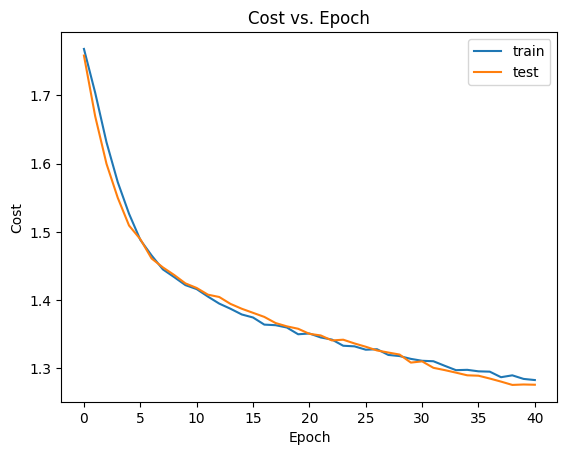

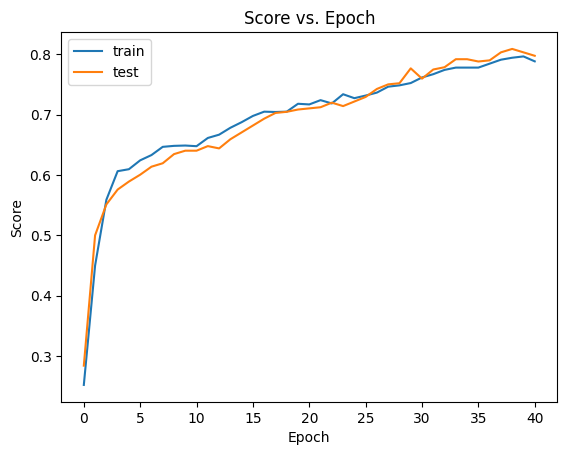

In [16]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [17]:
!pip install torchsummary

In [22]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)
    for class_idx, (count_labels, count_predictions) in enumerate(zip(class_counts_labels, class_counts_predictions)):
        print(f"Kelas {class_idx}: {count_labels} contoh dalam all_labels, {count_predictions} contoh dalam all_predictions")
    
    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))
    print(all_labels, all_predictions)

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Kelas 0: 44 contoh dalam all_labels, 43 contoh dalam all_predictions
Kelas 1: 44 contoh dalam all_labels, 36 contoh dalam all_predictions
Kelas 2: 44 contoh dalam all_labels, 67 contoh dalam all_predictions
Kelas 3: 44 contoh dalam all_labels, 19 contoh dalam all_predictions
Kelas 4: 44 contoh dalam all_labels, 44 contoh dalam all_predictions
Kelas 5: 44 contoh dalam all_labels, 55 contoh dalam all_predictions
Test Loss: 1.2694, Test Accuracy: 0.8258
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.97      0.80      0.88        44
           2       0.63      0.95      0.76        44
           3       0.68      0.30      0.41        44
           4       0.95      0.95      0.95        44
           5       0.80      1.00      0.89        44

    accuracy                           0.83       264
   macro avg       0.84      0.83      0.81       264
weighted avg       0.84      0.83 

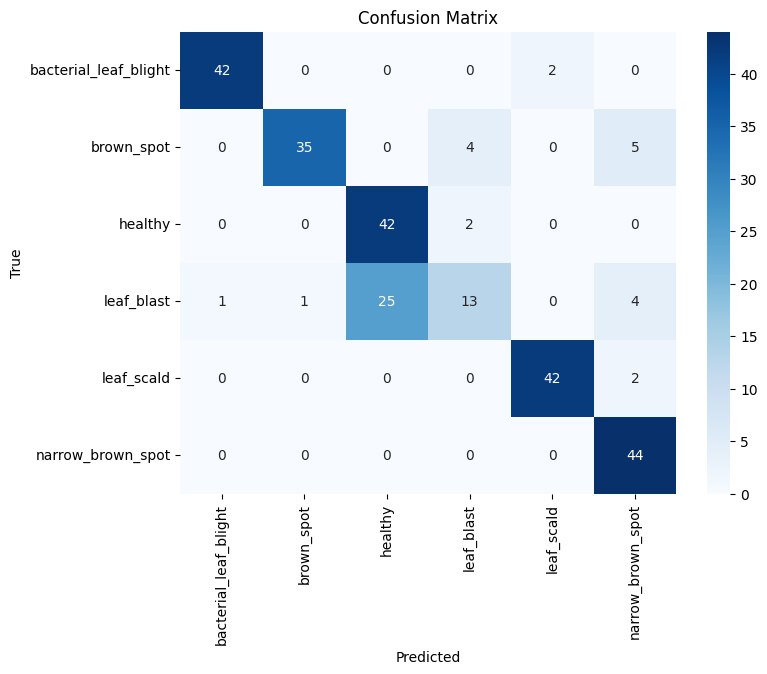

In [38]:
evaluate_model(model, testloader, criterion, device)

In [209]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [39]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_32/1340800542.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


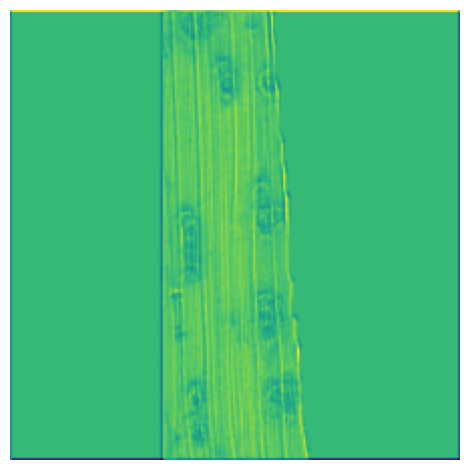

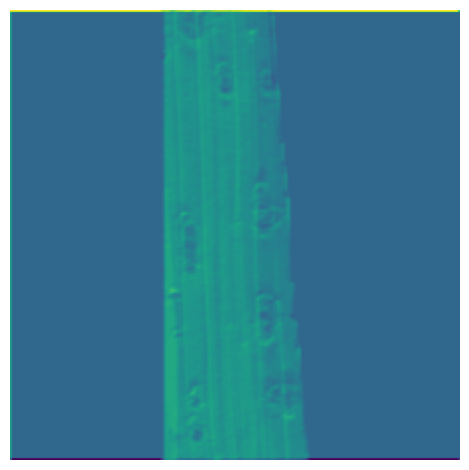

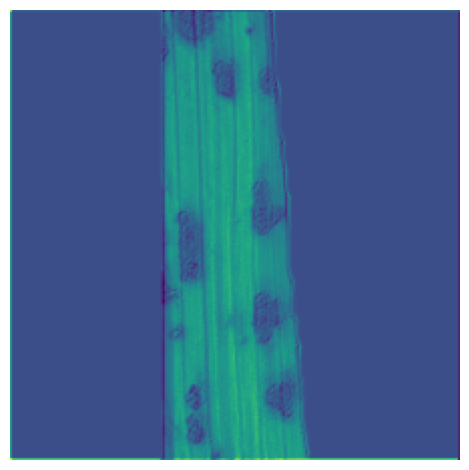

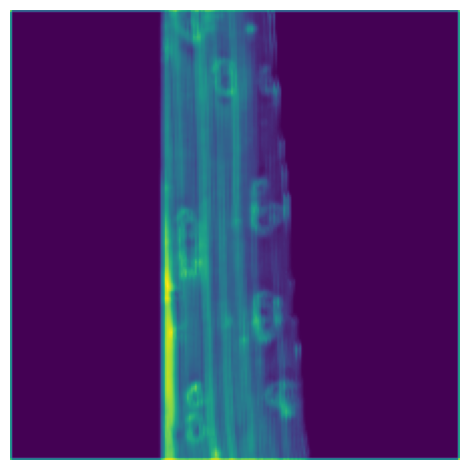

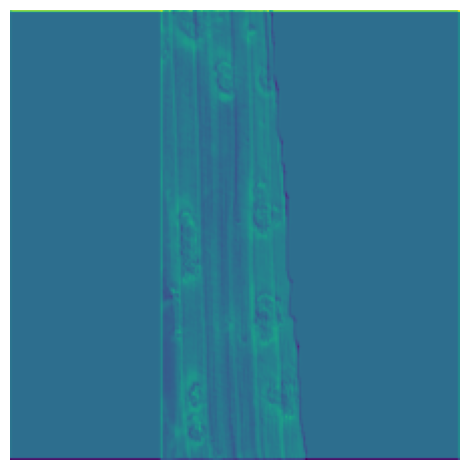

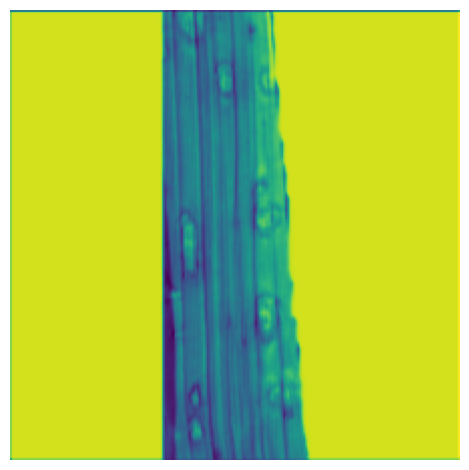

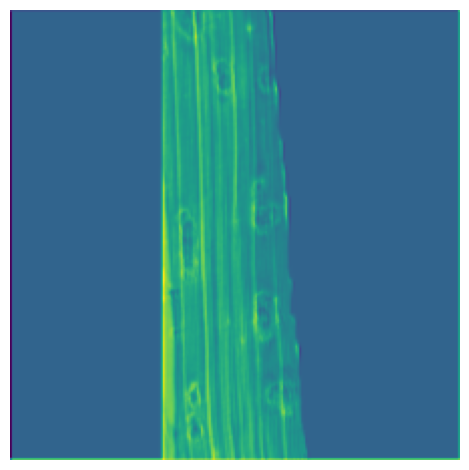

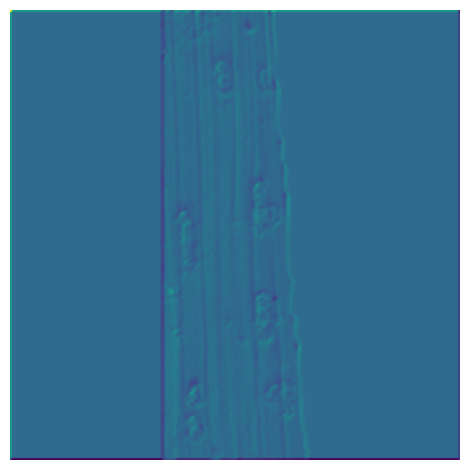

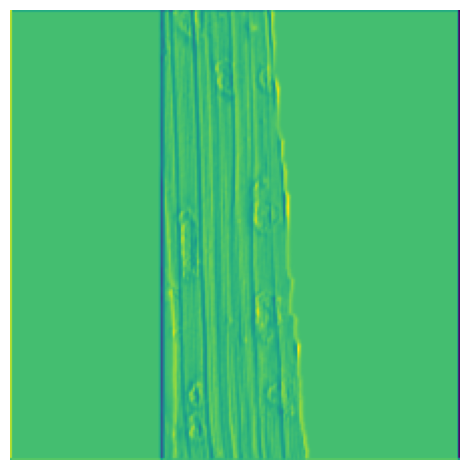

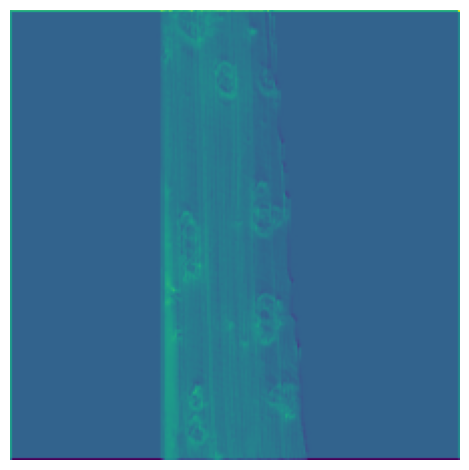

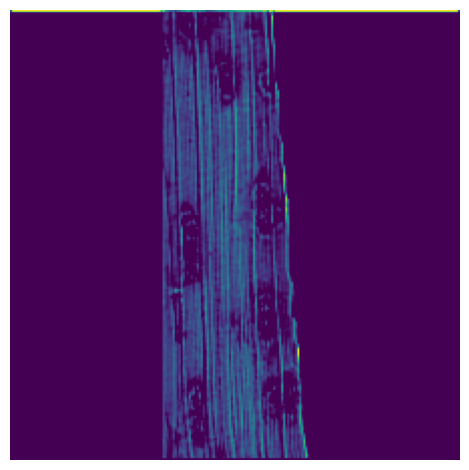

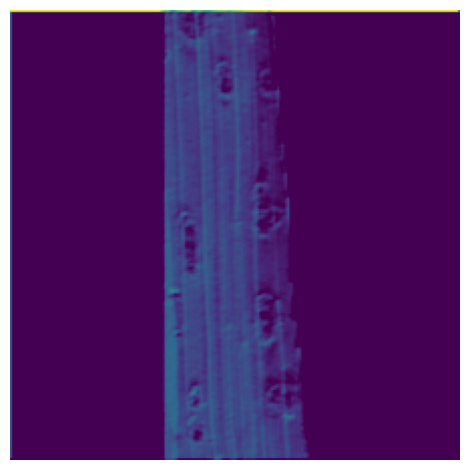

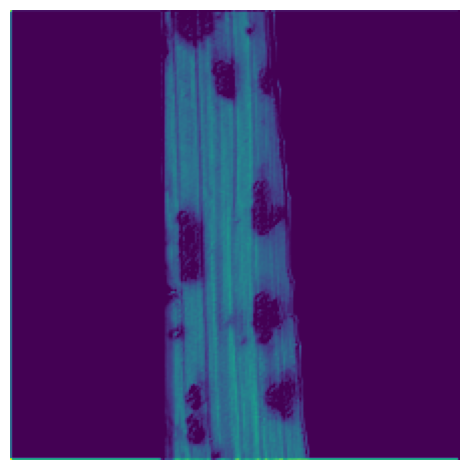

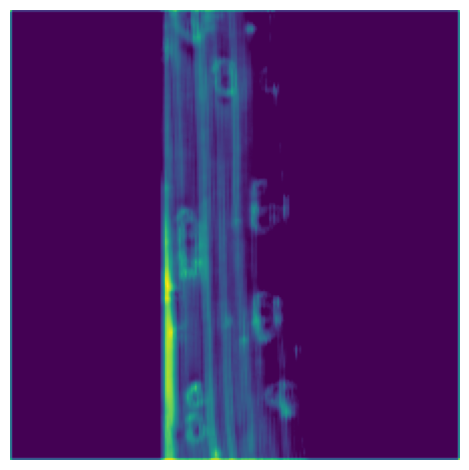

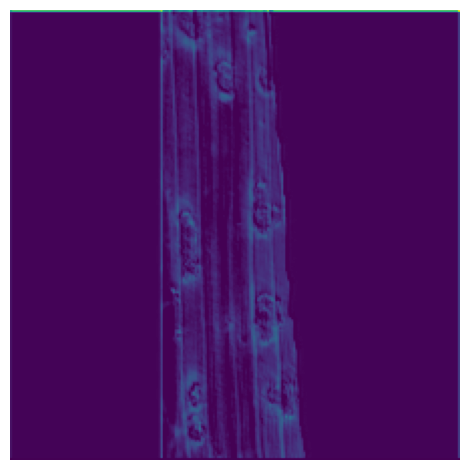

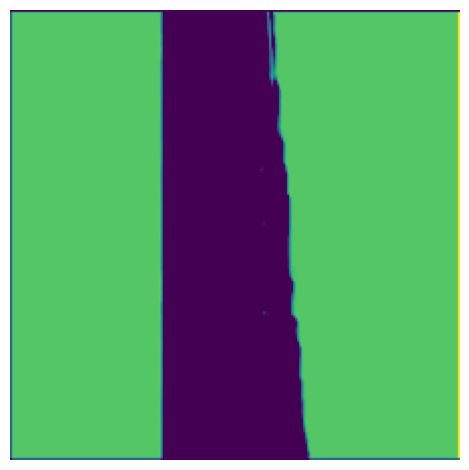

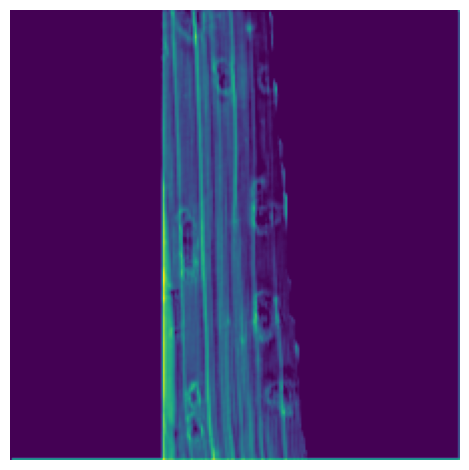

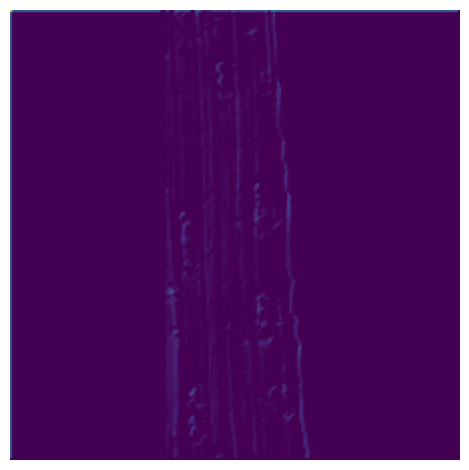

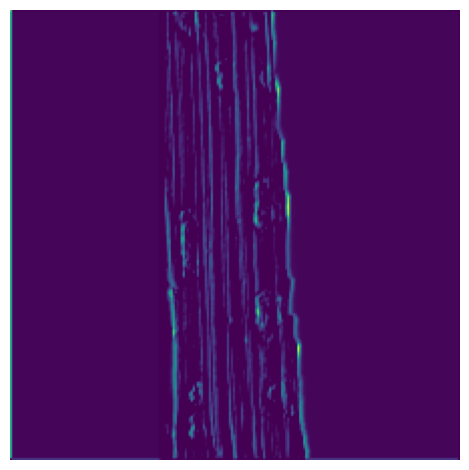

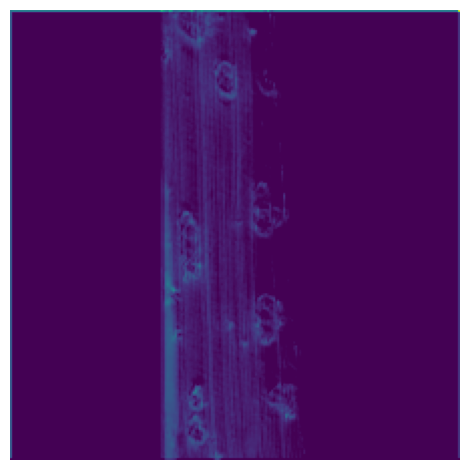

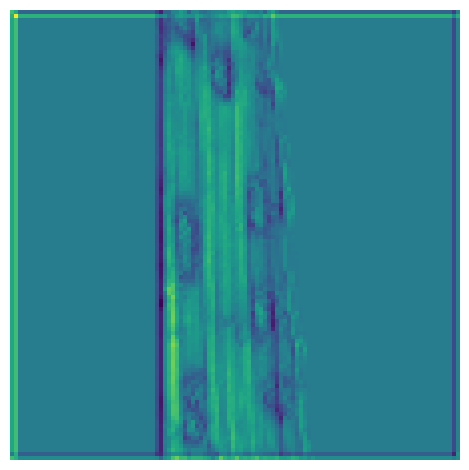

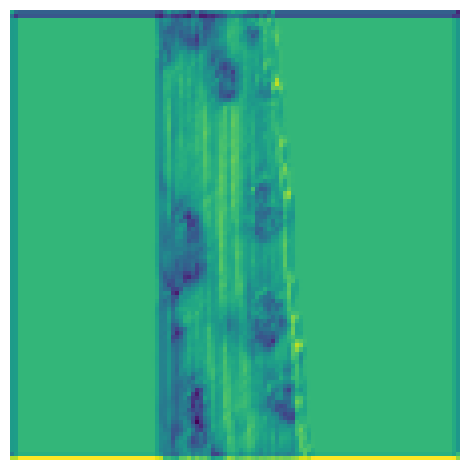

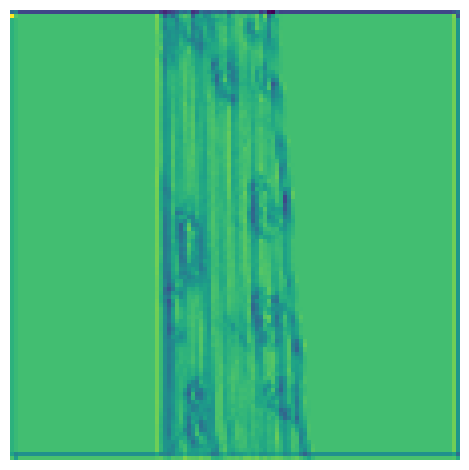

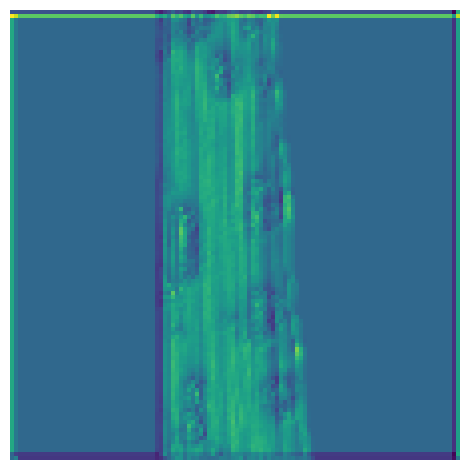

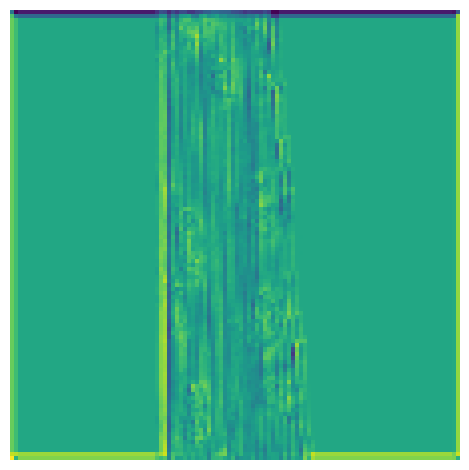

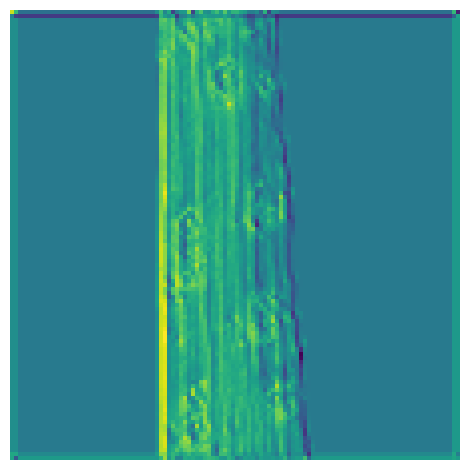

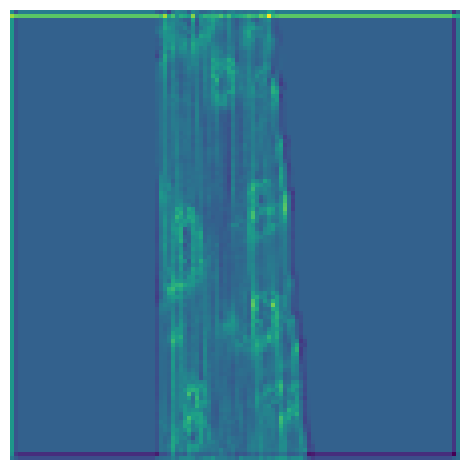

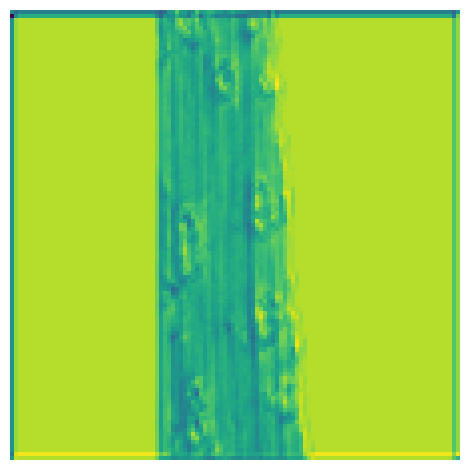

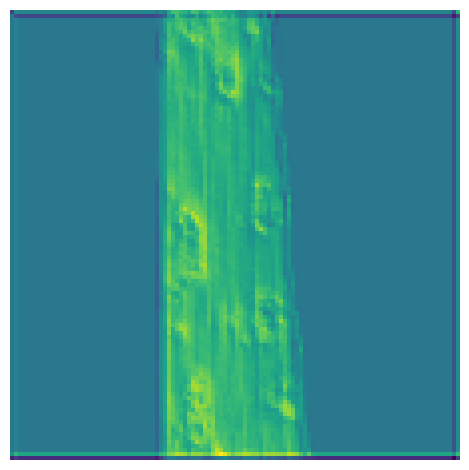

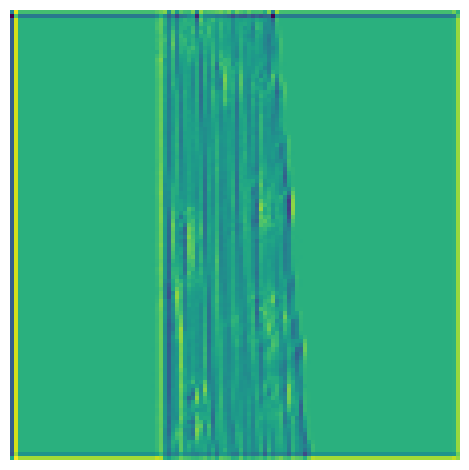

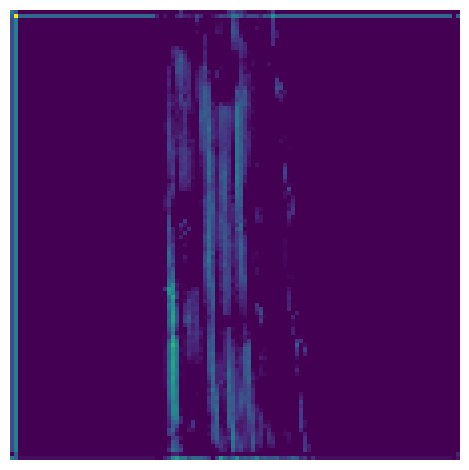

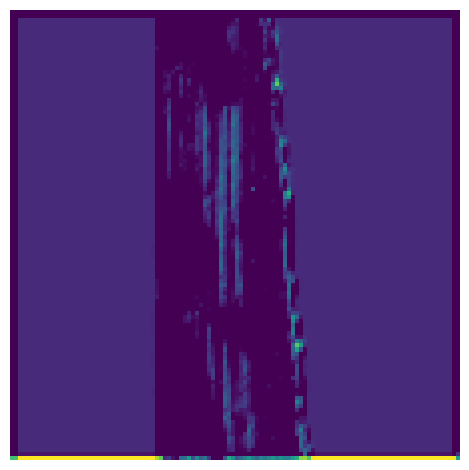

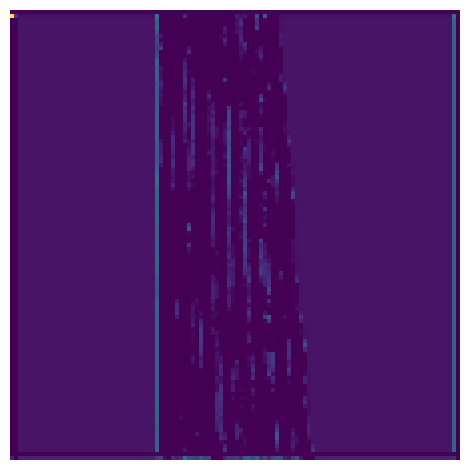

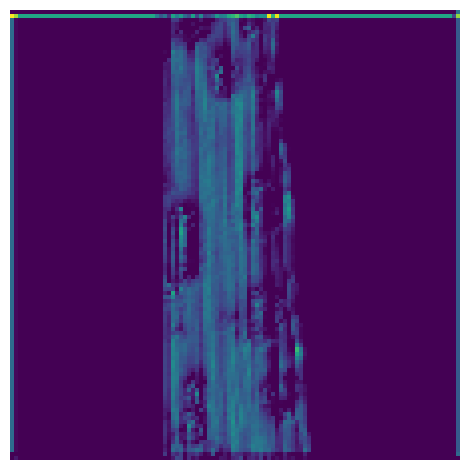

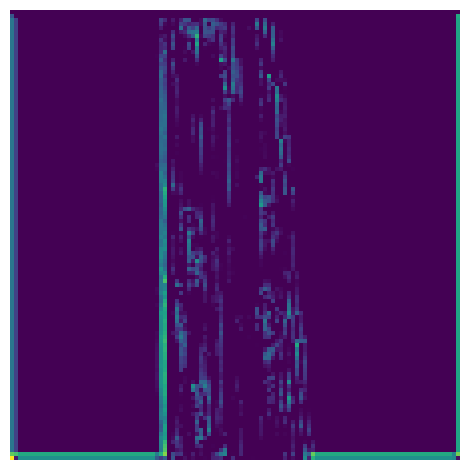

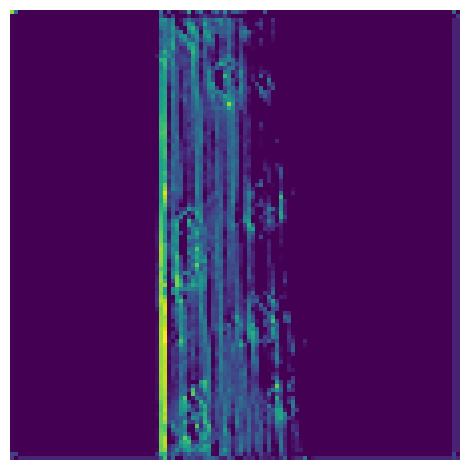

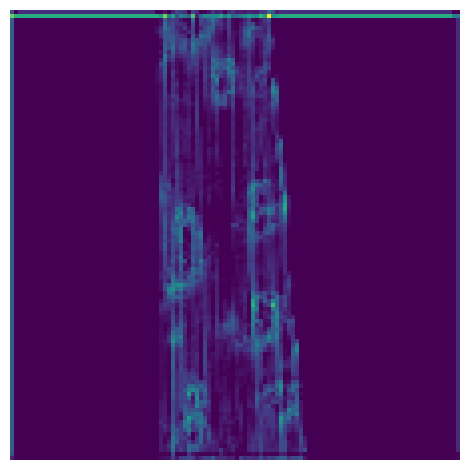

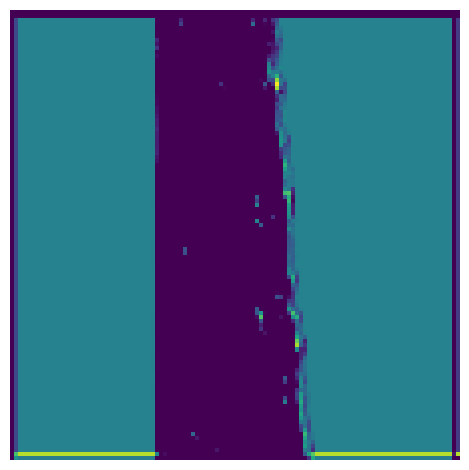

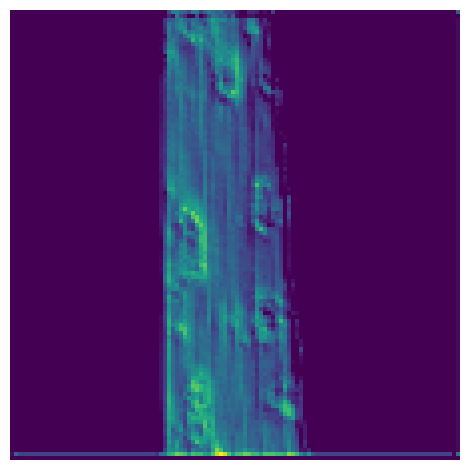

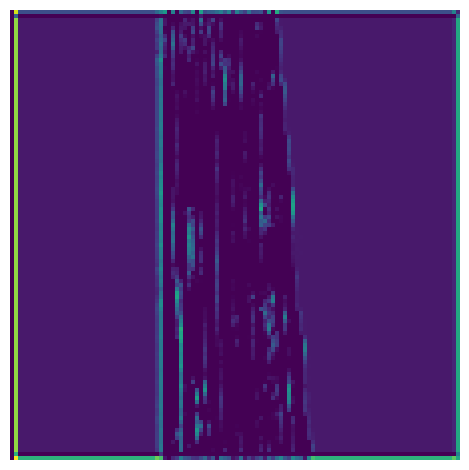

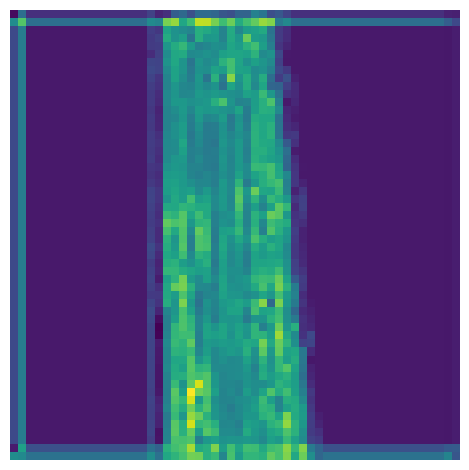

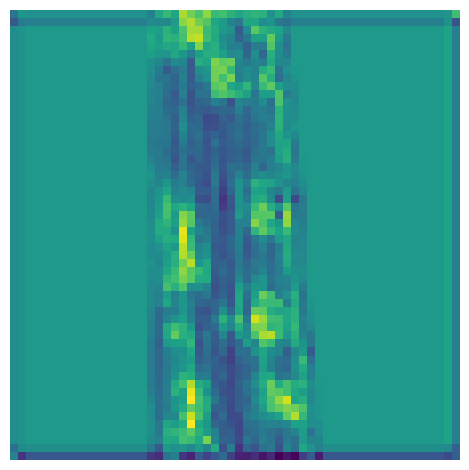

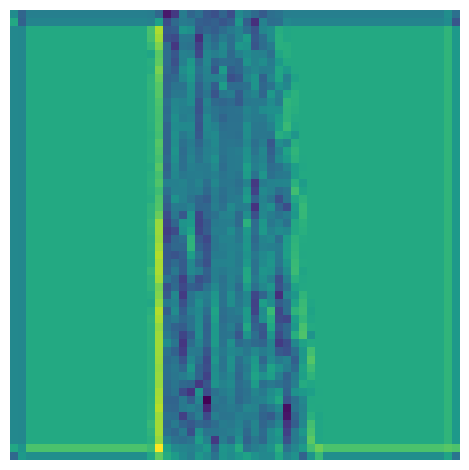

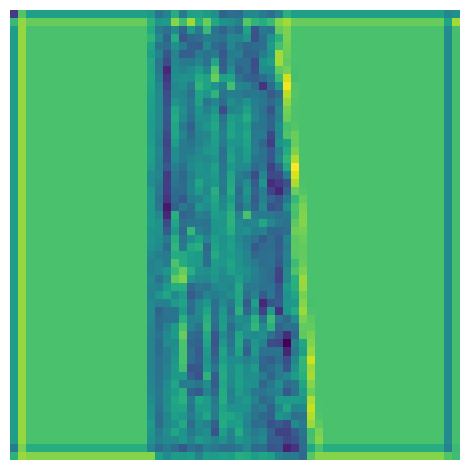

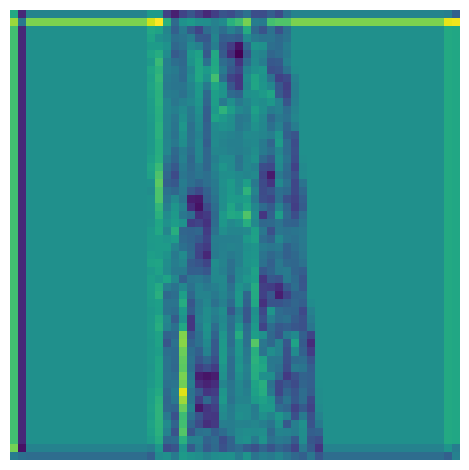

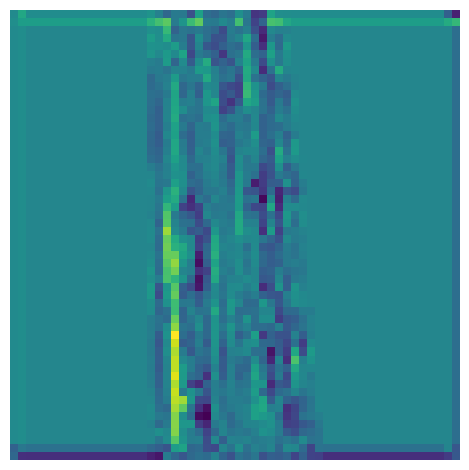

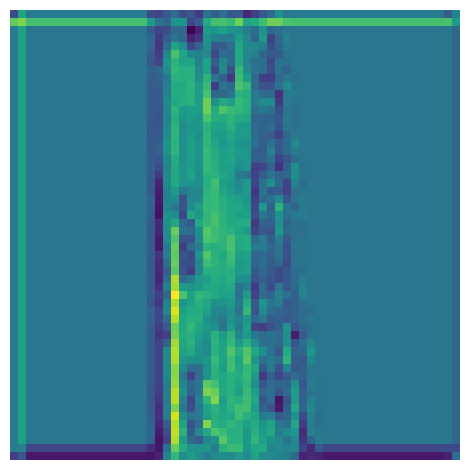

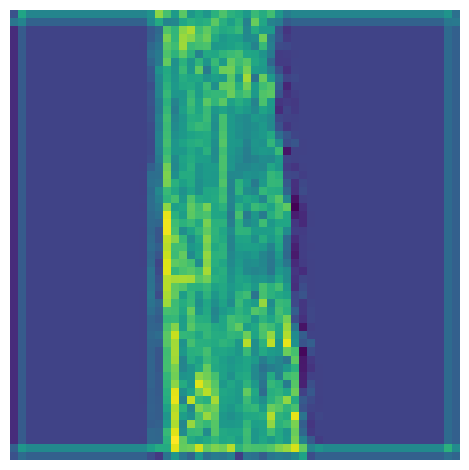

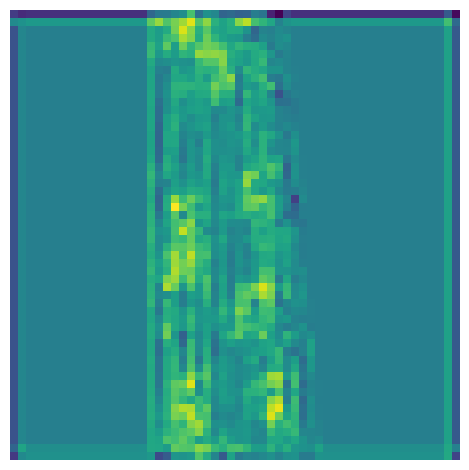

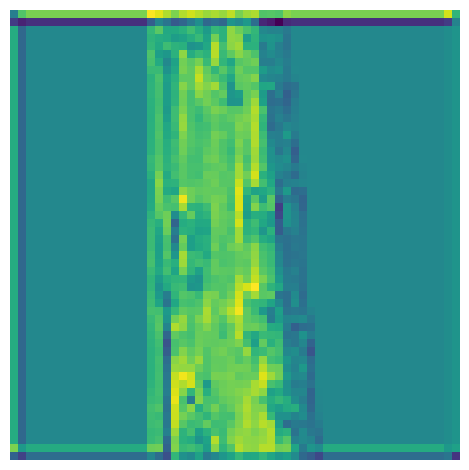

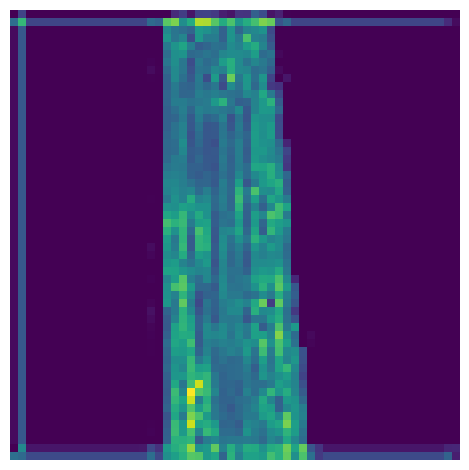

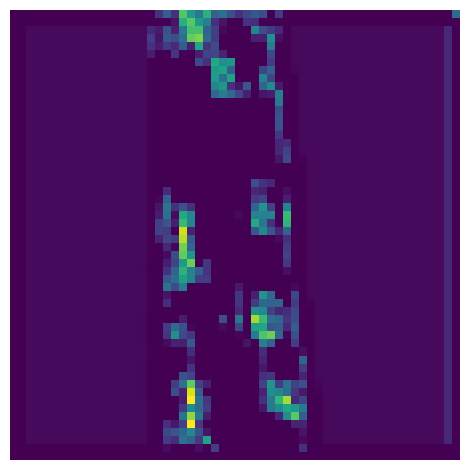

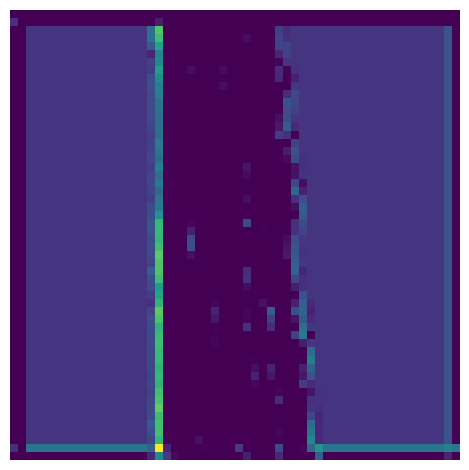

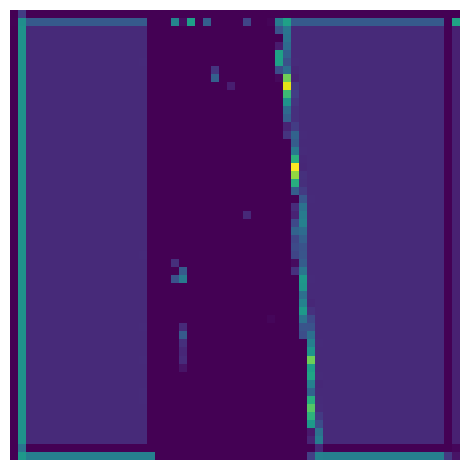

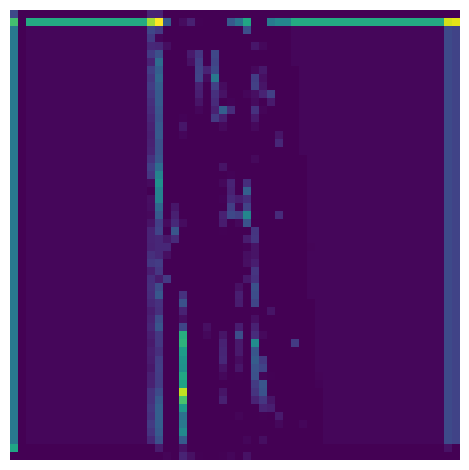

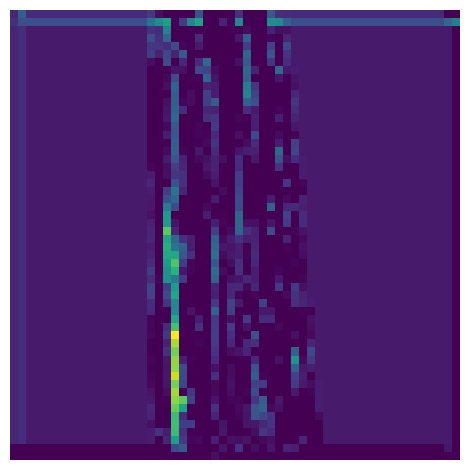

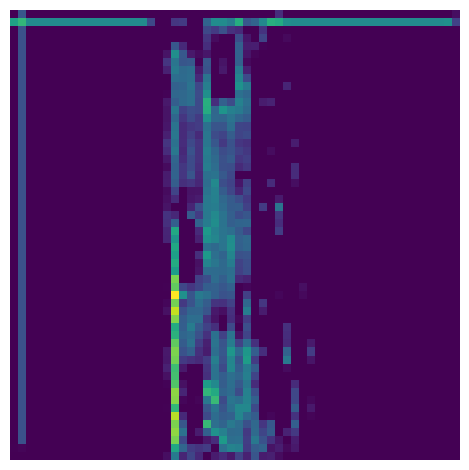

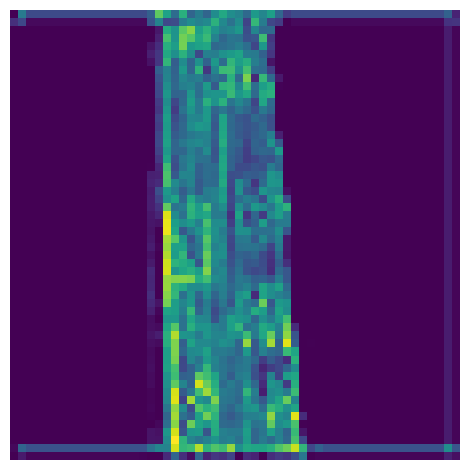

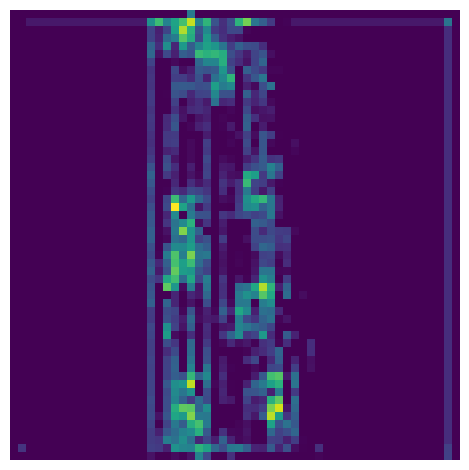

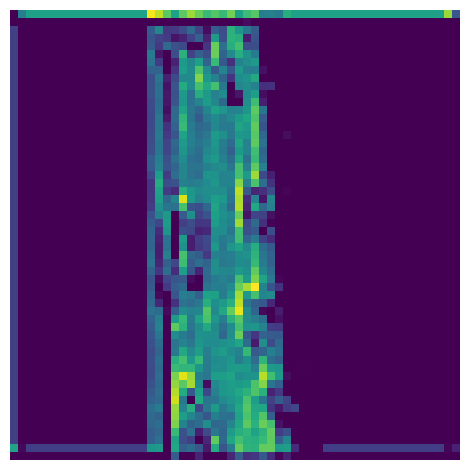

In [40]:
for name in activation1:
    folder_path = os.path.join('custom_1', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

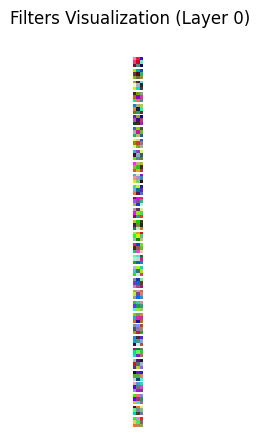

bias :tensor([-0.0359,  0.0219,  0.1696, -0.1286, -0.1152, -0.0753,  0.1360,  0.0401,
         0.0839, -0.1466, -0.1339,  0.0397, -0.1296,  0.1293,  0.0656,  0.0718,
        -0.0782, -0.0302,  0.1282, -0.0727, -0.1111, -0.1085, -0.0826, -0.1432,
         0.1509, -0.0538,  0.0488, -0.1355,  0.1801, -0.1425,  0.0512,  0.0171])


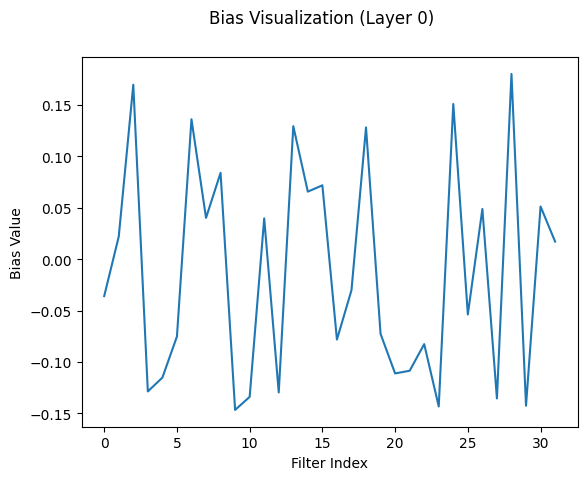

fitur :tensor([[[[-4.5391e-01, -6.7778e-01, -5.5660e-01, -5.3528e-01, -6.4037e-01,
           -5.3956e-01],
          [-6.5910e-01, -6.2226e-01, -4.7328e-01, -5.3600e-01, -6.1249e-01,
           -3.6907e-01],
          [-6.5657e-01, -6.1991e-01, -4.9000e-01, -5.1844e-01, -6.1106e-01,
           -3.6816e-01],
          [-6.5645e-01, -6.2690e-01, -4.6296e-01, -5.0202e-01, -5.9614e-01,
           -3.6658e-01],
          [-6.5371e-01, -6.0457e-01, -4.6695e-01, -4.7735e-01, -5.8303e-01,
           -3.6371e-01],
          [-2.2973e-01, -1.7662e-02,  1.4387e-01,  1.2817e-01,  4.7961e-02,
           -2.1063e-02]],

         [[-6.5435e-01, -8.7983e-01, -7.2997e-01, -7.3753e-01, -9.1679e-01,
           -8.2796e-01],
          [-8.6288e-01, -1.0248e+00, -8.9820e-01, -8.6896e-01, -1.0542e+00,
           -8.5825e-01],
          [-8.6357e-01, -1.0265e+00, -8.7362e-01, -8.3721e-01, -1.0297e+00,
           -8.5640e-01],
          [-8.6187e-01, -1.0166e+00, -8.4372e-01, -8.0741e-01, -1.0125e+00,
      

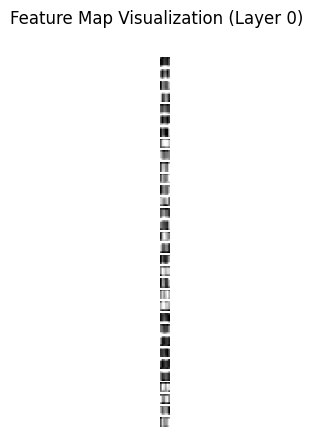

relu :tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1439, 0.1282, 0.0480, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.5962, 0.3235, 0.1831, 0.3372, 1.0661],
          [0.0000, 0.3913, 0.3070, 0.1401, 0.2288, 0.7221],
          [0.0000, 0.4143, 0.3047, 0.1250, 0.2228, 0.7212],
          [0.0000, 0.4272, 0.3069, 0.1098, 0.2187, 0.7218],
          [0.0000, 0.4291, 0.3

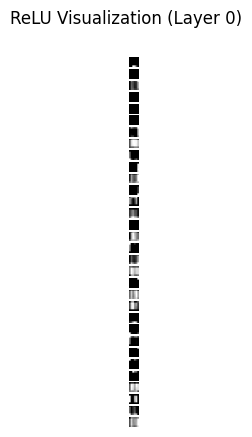

In [41]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)